# Matching GPX to OSM data

Importing packages

In [200]:
from shapely.geometry import Point, LineString
import numpy as np
import rasterio
from rtree import index
import networkx as nx
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from cartopy import crs
import xml.etree.ElementTree as ET
import gpxpy.gpx
from pyproj import CRS
from pyproj import Transformer

Importing the network

In [201]:
sheepstor_map = rasterio.open(
        os.path.join('OS Explorer Maps', 'Download_South+Dartmoor_2004150', 'raster-25k_4541337', 'sx', 'sx56.tif'))

path_network = gpd.read_file(os.path.join('Detailed-Path-Network', 'DARTMOOR NATIONAL PARK.gml'))

tree = ET.parse(os.path.join('Detailed-Path-Network', 'DARTMOOR NATIONAL PARK.gml'))

Importing the gpx data

In [202]:
gpx_file = open(os.path.join('Walking routes', 'Sheeps Tor.gpx'), 'r')

Creating the Network

In [203]:
def create_network(gml, gml_gpd):
    root = gml.getroot()
    startnodes = [startNode.attrib for startNode in
                  root.iter('{http://namespaces.os.uk/networks/detailedPathNetwork/1.0}startNode')]
    gml_gpd['startNodes'] = [nodes['{http://www.w3.org/1999/xlink}href'] for nodes in startnodes]
    endnodes = [endNode.attrib for endNode in
                root.iter('{http://namespaces.os.uk/networks/detailedPathNetwork/1.0}endNode')]
    gml_gpd['endNodes'] = [nodes['{http://www.w3.org/1999/xlink}href'] for nodes in endnodes]

    nodes_id = [nodes.attrib for nodes in
                root.iter('{http://namespaces.os.uk/networks/detailedPathNetwork/1.0}RouteNode')]
    node_ids = [node['{http://www.opengis.net/gml/3.2}id'] for node in nodes_id]

    network_coords = [geom.text for geom in root.iter('{http://www.opengis.net/gml/3.2}pos')]
    node_coordinates = []
    for i in network_coords:
        coords = i.split(" ")
        coords = [float(j) for j in coords]
        node_coordinates.append(coords)

    node_geom = [Point(node) for node in node_coordinates]

    network_nodes = gpd.GeoDataFrame({'fid': nodes_id, 'geometry': node_geom})

    graph = nx.Graph()
    for index, row in gml_gpd.iterrows():
        graph.add_edge(row['startNodes'], row['endNodes'], fid=row['gml_id'], weight=row['planimetricLength'])

    return graph, network_nodes


In [204]:
g, path_nodes = create_network(tree, path_network)

Create the index

In [205]:
def create_index(network_nodes):
    idx = index.Index()
    # set the bounds for the index
    for i in range(len(network_nodes['fid'])):
        left, bottom, right, top = (network_nodes['geometry'][i].x, network_nodes['geometry'][i].y,
                                    network_nodes['geometry'][i].x, network_nodes['geometry'][i].y)
        idx.insert(i, (left, bottom, right, top))
    return idx

In [206]:
idx = create_index(path_nodes)

Converting the gpx data

In [207]:
def import_gpx(gpx_file):
    gpx = gpxpy.parse(gpx_file)

    wsg84 = CRS.from_epsg(4326)
    osgb36 = CRS.from_epsg(27700)
    transformer = Transformer.from_crs(wsg84, osgb36)

    points = []
    if gpx.waypoints:
        waypoints = gpx.waypoints
    else:
        routes = gpx.routes
        waypoints = routes[0].points

    for waypoint in waypoints:
        points.append(transformer.transform(waypoint.latitude, waypoint.longitude))

    route_gpd = gpd.GeoSeries(LineString(points))
    # route_gpd.plot()

    bounds = []
    for bound in gpx.bounds:
        bounds.append(bound)
    top_right = (transformer.transform(bounds[1], bounds[3]))
    bottom_left = (transformer.transform(bounds[0], bounds[2]))

    return route_gpd, points, top_right, bottom_left

In [208]:
bluebell_walk, coords, top_right, bottom_left = import_gpx(gpx_file)

Finding the nearest nodes

In [209]:
def get_nearest_nodes(idx, network_nodes, first_point, point, global_nodes, global_missing_links):
    for i in idx.nearest(first_point, 1):
        first_coordinate = network_nodes['geometry'][i]
        # need to add # so that it is identified in with the link
        first_node = ("#" + network_nodes['fid'][i].get('{http://www.opengis.net/gml/3.2}id'))
        global_nodes.append(first_coordinate)
    for i in idx.nearest(point, 1):
        last_coordinate = network_nodes['geometry'][i]
        # need to add # so that it is identified in with the link
        last_node = ("#" + network_nodes['fid'][i].get('{http://www.opengis.net/gml/3.2}id'))
        global_nodes.append(last_coordinate)

    def calculate_hausdorff_distances():
        far_nearest_gpx = []
        far_nearest_node = []
        gpx_start = Point(first_point)
        node_start = Point(first_coordinate)
        print("Start point", gpx_start.hausdorff_distance(node_start))
        start_distance = gpx_start.hausdorff_distance(node_start)
        # if gpx_start.hausdorff_distance(node_start) > 50:
        #     far_nearest_gpx.append(gpx_start)
        #     far_nearest_node.append(node_start)
        gpx_end = Point(point)
        node_end = Point(last_coordinate)
        print("End point", gpx_end.hausdorff_distance(node_end))
        end_distance = gpx_end.hausdorff_distance(node_end)
        # if gpx_start.hausdorff_distance(node_start) > 50:
        #     far_nearest_gpx.append(gpx_end)
        #     far_nearest_node.append(node_end)
        return start_distance,end_distance

    start_distance,end_distance = calculate_hausdorff_distances()

    if first_coordinate == last_coordinate:
    #if first_coordinate == last_coordinate or( start_distance or end_distance > 240) :
        # print('Same node')
        # plt.plot(LineString(zip(first_point, point)))
        global_missing_links.append(LineString([first_point, point]))
    elif start_distance > 240 or end_distance > 240:
        print("Distance is greater then 240 meters")
        global_missing_links.append(LineString([first_point, point]))

    return first_coordinate, first_node, last_coordinate, last_node, start_distance, end_distance

Converting gpx to path

In [210]:
def gpx_to_path(first_node, last_node, g, path_network, global_geom, global_links, start_distance, end_distance):
    path = nx.dijkstra_path(g, first_node, last_node, weight='weight')
    if len(path) != 1 and (start_distance < 240 and end_distance < 240):
        geom = []
        links = []

        first_node = path[0]
        for node in path[1:]:
            link_fid = g.edges[first_node, node]['fid']
            links.append(link_fid)
            global_links.append(link_fid)
            row = path_network.loc[path_network['gml_id'] == link_fid]
            geom.append(row['geometry'].cascaded_union)
            global_geom.append(row['geometry'].cascaded_union)
            first_node = node

        path_gpd = gpd.GeoDataFrame({'fid': links, 'geometry': geom})
        # print('Plotting Path')
        # path_gpd.plot()
        return path_gpd

In [211]:
def plot_map(sheepstor_map, first_coordinate, last_coordinate, first_point,point,
             bluebell_walk, path_network, path_nodes, path_gpd):
    back_array = sheepstor_map.read(1)
    palette = np.array([value for key, value in sheepstor_map.colormap(1).items()])
    background_image = palette[back_array]
    bounds = sheepstor_map.bounds
    extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
    fig = plt.figure(figsize=(3, 3), dpi=500)
    ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())
    ax.imshow(background_image, origin='upper', extent=extent, zorder=0)
    plt.scatter(first_coordinate.bounds[0], first_coordinate.bounds[1], color='yellow', s=1, zorder=6)
    plt.scatter(last_coordinate.bounds[0], last_coordinate.bounds[1], color='yellow', s=1, zorder=6)

    bluebell_walk.plot(ax=ax, edgecolor='red', linewidth=0.5, zorder=2)
    plt.scatter(first_point[0], first_point[1], color='red', s=1, zorder=3)
    plt.scatter(point[0], point[1], color='red', s=1, zorder=3)

    path_network.plot(ax=ax, edgecolor='blue', linewidth=0.5, zorder=4)
    path_nodes.plot(ax=ax, color='blue', markersize=1, zorder=4)

    path_gpd.plot(ax=ax, edgecolor='green', linewidth=2, zorder=5)
    display_extent = ((first_coordinate.bounds[0] - 500, first_coordinate.bounds[0] + 500,
                       first_coordinate.bounds[1] - 500, first_coordinate.bounds[1] + 500))
    ax.set_extent(display_extent, crs=crs.OSGB())
    plt.show()

In [212]:
global_geom = []
global_links = []
global_nodes = []
global_missing_links = []
start_point = coords[0]
for coord in coords[1:]:
    first_coordinate, first_node, last_coordinate, last_node,  start_distance, end_distance = get_nearest_nodes(
                                                                                 idx, path_nodes, start_point, coord, global_nodes,
                                                                                 global_missing_links)
    path_gpd = gpx_to_path(first_node, last_node, g, path_network, global_geom, global_links, start_distance, end_distance)
    # if first_coordinate != last_coordinate:
    #     plot_map(sheepstor_map, first_coordinate, last_coordinate, start_point,coord,
    #          bluebell_walk, path_network, path_nodes, path_gpd)
    # else:
    #     print('Start and End node are the same')
    start_point = coord
global_path_gpd = gpd.GeoDataFrame({'fid': global_links, 'geometry': global_geom})
#global_path_gpd.to_file("Blubell_walk_gpd")
global_nodes_gpd = gpd.GeoDataFrame({'geometry': global_nodes})

Start point 7.437107763826671
End point 76.69067200674439
Start point 76.69067200674439
End point 34.95144274343125
Start point 34.95144274343125
End point 164.52408307379457
Start point 164.52408307379457
End point 183.08877914354912
Start point 183.08877914354912
End point 236.33710964464646
Start point 236.33710964464646
End point 134.21434436528216
Start point 134.21434436528216
End point 127.87516814202311
Start point 127.87516814202311
End point 110.18347559057405
Start point 110.18347559057405
End point 131.06321306122865
Start point 131.06321306122865
End point 112.3673549561664
Start point 112.3673549561664
End point 210.69672110146158
Start point 210.69672110146158
End point 312.1380631876219
Start point 312.1380631876219
End point 313.5008970813511
Start point 313.5008970813511
End point 319.0200827563524
Distance is greater then 240 meters
Start point 319.0200827563524
End point 260.76841870004534
Distance is greater then 240 meters
Start point 260.76841870004534
End point 

Finding the missing sections

In [213]:
def calculate_missing_sections(global_missing_links, path_gpd, points):
    missing_links = []
    path_geoseries = gpd.GeoSeries(path_gpd['geometry'])
    # account for missing nodes that are on the path due to being so small there nodes were the same
    for link in global_missing_links:
        if not any(path_geoseries.intersects(link)):

            missing_links.append(link)
    # global_missing_links_gpd = gpd.GeoSeries(global_missing_links)
    global_missing_links_gpd = gpd.GeoSeries(missing_links)
    # global_missing_links_gpd.to_file("global_missing_links_gpd")

    missing_length = ((len(global_missing_links_gpd) / (len(points) - 1))*100)
    print("Percentage of Path missing in network is", missing_length, "%")

    return global_missing_links_gpd

In [214]:
global_missing_links_gpd = calculate_missing_sections(global_missing_links, global_path_gpd, coords)

Percentage of Path missing in network is 46.478873239436616 %


Plot missing links

<AxesSubplot:>

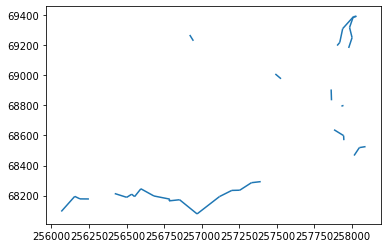

In [215]:
global_missing_links_gpd.plot()

Plot new path

In [216]:
def plot_global_map(raster_map, global_nodes_gpd, points,
                    route_gpd, path_network, path_nodes, path_gpd, top_right, bottom_left, global_missing_links_gpd):
    back_array = raster_map.read(1)
    palette = np.array([value for key, value in raster_map.colormap(1).items()])
    background_image = palette[back_array]
    bounds = raster_map.bounds
    extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
    fig = plt.figure(figsize=(3, 3), dpi=500)

    ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())
    ax.imshow(background_image, origin='upper', extent=extent, zorder=0)
    route_gpd.plot(ax=ax, edgecolor='blue', linewidth=0.5, zorder=2)
    plt.scatter(*zip(*points), color='blue', s=1, zorder=3)

    # path_network.plot(ax=ax, edgecolor='blue', linewidth=0.5, zorder=4)
    # path_nodes.plot(ax=ax, color='blue', markersize=1, zorder=4)

    global_missing_links_gpd.plot(ax=ax, color='red', linewidth=1, zorder=6)

    path_gpd.plot(ax=ax, edgecolor='green', linewidth=1, zorder=5)
    global_nodes_gpd.plot(ax=ax, color='yellow', markersize=1, zorder=5)

    display_extent = ((bottom_left[0] - 100, top_right[0] + 100,
                       bottom_left[1] - 100, top_right[1] + 100))
    ax.set_extent(display_extent, crs=crs.OSGB())
    plt.show()

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:25: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


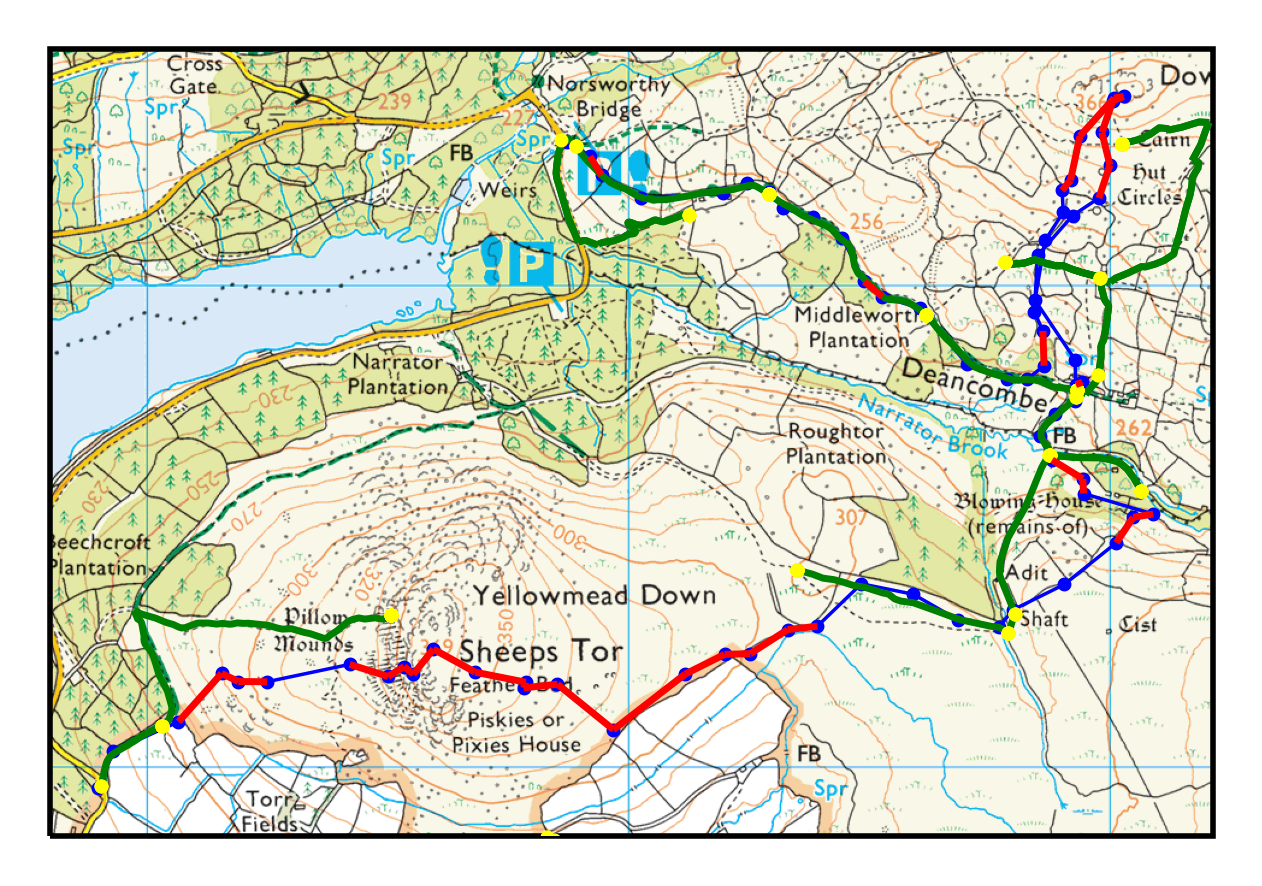

In [217]:
plot_global_map(sheepstor_map, global_nodes_gpd, coords,
                    bluebell_walk, path_network, path_nodes, global_path_gpd, top_right, bottom_left,
                    global_missing_links_gpd)